In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, log_loss
from sklearn.model_selection import PredefinedSplit, KFold
from alpha_vantage.timeseries import TimeSeries
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, BatchNormalization
from collections import Counter
import warnings
import time
import tensorflow as tf

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Define stock tickers for analysis and fetching data of multiple stocks

In [3]:
#tickers = ["TSLA", "AAPL", "MSFT", "GOOGL", "AMZN" ,"ORCL" ,"INTC" ,"NVDA" ,"META" ,"BABA"] # Turbulent stocks
tickers = ["HDB"] # Stable stocks
# Can add more tickers as needed

In [4]:
# Creating features and target for Machine learning

In [5]:
# Using Yahoo Finance

def fetch_stock_data(ticker):
    try:
        data = yf.download(ticker, interval='1d', period='10y')           # if error occurs at train test size i.e. it says no data then changle interval to '5m' and period to '5d'
        if data.empty:
            print(f"No data returned for {ticker}")
            return pd.DataFrame()
        data.columns = ['open', 'high', 'low', 'close', 'volume']
        data['Return'] = data['close'].pct_change()
        data['Target'] = (data['close'].shift(-5) > data['close'] * 1.02)

        # Missing value handling
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.ffill(inplace=True)
        data.bfill(inplace=True)
        data.dropna(inplace=True)
        
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [6]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [7]:
def compute_atr(high, low, close, period=14):
    tr = np.maximum(high - low,
                   np.maximum(abs(high - close.shift(1)),
                   abs(low - close.shift(1))))
    return tr.rolling(window=period).mean()

In [8]:
def compute_adx(high, low, close, period=14):
    plus_dm = high.diff()
    minus_dm = -low.diff()
    plus_dm[~(plus_dm > minus_dm)] = 0
    minus_dm[~(minus_dm > plus_dm)] = 0
    
    tr = np.maximum(high - low,
                   np.maximum(abs(high - close.shift(1)),
                   abs(low - close.shift(1))))
    atr = tr.rolling(window=period).mean()
    
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / atr)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

In [9]:
def compute_parabolic_sar(high, low, close, acceleration=0.02, maximum=0.2):
    sar = close.copy()
    trend = 1  # 1 for uptrend, -1 for downtrend
    ep = high[0] if trend == 1 else low[0]
    af = acceleration
    
    for i in range(1, len(close)):
        if trend == 1:
            sar[i] = sar[i-1] + af * (ep - sar[i-1])
            if high[i] > ep:
                ep = high[i]
                af = min(af + acceleration, maximum)
            if sar[i] > low[i]:
                trend = -1
                sar[i] = ep
                ep = low[i]
                af = acceleration
        else:
            sar[i] = sar[i-1] + af * (ep - sar[i-1])
            if low[i] < ep:
                ep = low[i]
                af = min(af + acceleration, maximum)
            if sar[i] < high[i]:
                trend = 1
                sar[i] = ep
                ep = high[i]
                af = acceleration
    return sar

In [10]:
def add_technical_indicators(data):

    # Price Action
    data['Typical_Price'] = (data['high'] + data['low'] + data['close']) / 3
    
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['RSI_14'] = compute_rsi(data['close'], period=14)
    data['Parabolic_SAR'] = compute_parabolic_sar(data['high'], data['low'], data['close'])

    # Trend
    data['ADX_14'] = compute_adx(data['high'], data['low'], data['close'])
    
    # Volatility
    data['ATR_14'] = compute_atr(data['high'], data['low'], data['close'])
    data['Bollinger_%B'] = (data['close'] - data['SMA_20']) / (2 * data['close'].rolling(20).std())
    
    # Smart Features
    data['VWAP'] = (data['volume'] * data['Typical_Price']).cumsum() / data['volume'].cumsum()
    data['Night_Gap'] = (data['open'] - data['close'].shift(1)) / data['ATR_14']
    
    # Volume Indicators
    data['Bollinger_Upper'] = data['SMA_20'] + 2 * data['close'].rolling(window=20).std()
    data['Bollinger_Lower'] = data['SMA_20'] - 2 * data['close'].rolling(window=20).std()
    data['Volume_Z'] = (data['volume'] - data['volume'].rolling(20).mean()) / data['volume'].rolling(20).std()

    for lag in [1, 2, 3]:  # Only most recent lags
        data[f'return_lag_{lag}'] = data['close'].pct_change(lag).shift(1)
    
    data.dropna(inplace=True)
    return data

In [11]:
# Fetch and process data for all tickers

In [12]:
all_data = {}
for ticker in tickers:
    print(f"Fetching data for {ticker}...")
    data = fetch_stock_data(ticker)
    if not data.empty:
        all_data[ticker] = add_technical_indicators(data)
    else:
        print(f"Skipping {ticker} due to missing data")

Fetching data for HDB...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [13]:
all_data[tickers[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2489 entries, 2015-06-03 to 2025-04-24
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2489 non-null   float64
 1   high             2489 non-null   float64
 2   low              2489 non-null   float64
 3   close            2489 non-null   float64
 4   volume           2489 non-null   int64  
 5   Return           2489 non-null   float64
 6   Target           2489 non-null   bool   
 7   Typical_Price    2489 non-null   float64
 8   SMA_5            2489 non-null   float64
 9   SMA_20           2489 non-null   float64
 10  RSI_14           2489 non-null   float64
 11  Parabolic_SAR    2489 non-null   float64
 12  ADX_14           2489 non-null   float64
 13  ATR_14           2489 non-null   float64
 14  Bollinger_%B     2489 non-null   float64
 15  VWAP             2489 non-null   float64
 16  Night_Gap        2489 non-null   float64
 

In [14]:
all_data[tickers[0]].head()

,open,high,low,close,volume,Return,Target,Typical_Price,SMA_5,SMA_20,...,ATR_14,Bollinger_%B,VWAP,Night_Gap,Bollinger_Upper,Bollinger_Lower,Volume_Z,return_lag_1,return_lag_2,return_lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-03,27.030268,27.767586,26.959373,27.649426,1755600,0.006192,False,27.458795,27.875347,27.295655,...,0.578309,0.255964,27.158887,-0.776413,28.677767,25.913543,0.679319,-0.024497,-0.022693,-0.017241
2015-06-04,26.935740,27.219323,26.860117,27.134247,1598800,-0.018633,False,27.071229,27.709923,27.331812,...,0.602954,-0.149538,27.155687,-1.183651,28.652984,26.010641,0.237023,0.006192,-0.018456,-0.016642
2015-06-05,27.077532,27.105889,26.543448,26.912107,1283000,-0.008187,False,26.853815,27.468876,27.394673,...,0.605655,-0.445387,27.147094,-0.093643,28.478150,26.311197,-0.626730,-0.018633,-0.012556,-0.036745
2015-06-08,26.689968,27.124796,26.656883,26.968826,980400,0.002108,False,26.916835,27.228776,27.414997,...,0.607680,-0.432439,27.142193,-0.365552,28.446751,26.383242,-1.318965,-0.008187,-0.026667,-0.020640
2015-06-09,26.557629,26.940468,26.482006,26.803402,858800,-0.006134,False,26.741958,27.093602,27.399872,...,0.609368,-0.563063,27.134866,-0.674793,28.459205,26.340540,-1.466619,0.002108,-0.006096,-0.024615


In [15]:
all_data[tickers[0]].tail()

,open,high,low,close,volume,Return,Target,Typical_Price,SMA_5,SMA_20,...,ATR_14,Bollinger_%B,VWAP,Night_Gap,Bollinger_Upper,Bollinger_Lower,Volume_Z,return_lag_1,return_lag_2,return_lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-17,72.040001,72.339996,70.360001,70.440002,5530200,0.007870,False,71.046666,68.228001,65.8940,...,2.450714,1.181300,52.837248,0.877296,69.742306,62.045694,0.690811,0.025381,0.032501,0.075893
2025-04-21,73.769997,75.339996,73.000000,73.500000,4154300,0.043441,False,73.946665,69.936002,66.3755,...,2.684284,1.420643,52.856565,1.240552,71.390483,61.360518,-0.084094,0.007870,0.033451,0.040626
2025-04-22,75.180000,75.370003,73.529999,74.250000,4816400,0.010204,False,74.383334,71.248001,66.8080,...,2.747856,1.218689,52.879379,0.611386,72.914562,60.701439,0.264452,0.043441,0.051653,0.078345
2025-04-23,72.290001,73.250000,71.610001,72.519997,4301700,-0.023300,False,72.459999,72.120000,67.1570,...,2.818570,0.814940,52.897896,-0.695388,73.737850,60.576150,-0.063384,0.010204,0.054089,0.062384
2025-04-24,72.165001,72.364998,71.610001,72.239998,1869627,-0.003861,False,72.071665,72.589999,67.5015,...,2.750713,0.687101,52.905773,-0.129056,74.397861,60.605139,-1.346581,-0.023300,-0.013333,0.029529


In [16]:
# Combine all tickers' data
combined_data = pd.concat([df.assign(ticker=ticker) for ticker, df in all_data.items()])

# More robust feature selection
threshold = len(combined_data) * 0.95
combined_data = combined_data.dropna(axis=1, thresh=threshold)
combined_data = combined_data.ffill().dropna()

# Prepare features and target
X = combined_data.drop(columns=['Target', 'Return', 'ticker'])  # Remove target and raw return
y = combined_data['Target']

In [17]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (2489, 21), y shape: (2489,)


In [18]:
#Creating X and y features(spliting for predictions)

In [19]:
tscv = TimeSeriesSplit(n_splits=5)
selected_features_list = []

In [20]:
for train_index, test_index in tscv.split(X):
    X_train_fs, X_test_fs = X.iloc[train_index], X.iloc[test_index]
    y_train_fs, y_test_fs = y.iloc[train_index], y.iloc[test_index]
    
    selector = SelectKBest(score_func=f_classif, k=15)
    selector.fit(X_train_fs, y_train_fs)
    selected_features = X.columns[selector.get_support()]
    selected_features_list.append(selected_features)

feature_counts = Counter([f for sublist in selected_features_list for f in sublist])
final_features = [f for f, count in feature_counts.items() if count >= 3]
print("\nConsistently selected features:", final_features)


Consistently selected features: ['open', 'high', 'low', 'close', 'volume', 'Typical_Price', 'SMA_5', 'SMA_20', 'Parabolic_SAR', 'ADX_14', 'Night_Gap', 'Bollinger_Upper', 'Bollinger_Lower', 'return_lag_3', 'ATR_14']


In [21]:
X = X[final_features].dropna()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=final_features, index=X.index)

In [22]:
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [23]:
#Using GradientBoostingClassifier(Hyperparameter and XGBoosting tuning included)

In [24]:
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 8],  
    'subsample': [0.8, 0.9] 
}

In [25]:
gb_model = GradientBoostingClassifier(max_depth=5, learning_rate=0.1, random_state=10)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                          scoring='f1', cv=TimeSeriesSplit(n_splits=5), 
                          verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters for Gradient Boosting:", grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.9}


In [26]:
# Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting: ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting:  [0.44514107 0.26086957 0.304      0.29807692 0.16      ]
Mean F1 Score:  0.2936175108250071


In [27]:
gb_hyp_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=10)
gb_hyp_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=8,
                           min_samples_split=10, n_estimators=300,
                           random_state=10, subsample=0.9)

In [28]:
# Cross-Validation for Gradient Boosting (Hyperparameter tunned)
cv_scores = cross_val_score(gb_hyp_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting(tuned): ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(tuned):  [0.44094488 0.32234432 0.2601626  0.34166667 0.19895288]
Mean F1 Score:  0.31281427042158416


In [29]:
if XGBOOST_AVAILABLE:
    print("\nTraining XGBoost model...")
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=10,
        n_jobs=-1
    )
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    xgb_grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=xgb_param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='f1',
        verbose=1,
        n_jobs=-1
    )
    xgb_grid.fit(X_train, y_train)
    best_xgb = xgb_grid.best_estimator_
else:
    print("\nXGBoost not available - using enhanced GBC")
    best_xgb = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=10
    )
    best_xgb.fit(X_train, y_train)


Training XGBoost model...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [30]:
def create_time_series_splits(X, n_splits=5):
    split_index = np.full(X.shape[0], -1)
    split_size = len(X) // n_splits
    for i in range(n_splits):
        start = i * split_size
        end = (i + 1) * split_size if i != n_splits - 1 else len(X)
        split_index[start:end] = i
    return PredefinedSplit(split_index)

In [31]:
if XGBOOST_AVAILABLE:
    base_models = [
        ('xgb', best_xgb),
        ('gb', gb_hyp_model)
    ]
else:
    base_models = [
        ('gb1', gb_hyp_model),
        ('gb2', gb_model)
    ]

groups = np.array([i // (len(X_train) // 5) for i in range(len(X_train))])
ps = PredefinedSplit(groups)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=ps ,
    n_jobs=-1,
    passthrough=True 
)
stacking_model.fit(X_train.values, y_train.values)

voting_model = VotingClassifier(
    estimators=base_models + [('lr', LogisticRegression())],
    voting='soft',
    n_jobs=-1
)
voting_model.fit(X_train.values, y_train.values)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_con...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=5,
                                                         min_samples_leaf=8,
                                                         min_samples_split=10,
                                                         n_estimators=300,
                                                         random_state=10,
                                                         subsample=0.9)),
                             ('lr', LogisticRegression())],
                 n_jobs=-1, voting='soft')

In [32]:
models_gbc = {
    'Original GB': gb_hyp_model,
    'XGBoost/Enhanced GB': best_xgb,
    'Stacking Ensemble': stacking_model,
    'Voting Ensemble': voting_model
}

In [33]:
# Cross-Validation (Final)
for name, model in models_gbc.items():
    cv_scores = cross_val_score(
        model, X, y, cv=5, scoring='f1')
    print(f"Cross-Validation F1 Scores for Gradient Boosting(models_gbc = {name}): ", cv_scores)
    print(f"Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(models_gbc = Original GB):  [0.44094488 0.32234432 0.2601626  0.34166667 0.19895288]
Mean F1 Score:  0.31281427042158416
Cross-Validation F1 Scores for Gradient Boosting(models_gbc = XGBoost/Enhanced GB):  [0.36165577 0.39735099 0.29959514 0.41314554 0.21761658]
Mean F1 Score:  0.3378728057430703
Cross-Validation F1 Scores for Gradient Boosting(models_gbc = Stacking Ensemble):  [0.23880597 0.0137931  0.20338983 0.04054054        nan]
Mean F1 Score:  nan
Cross-Validation F1 Scores for Gradient Boosting(models_gbc = Voting Ensemble):  [0.41254125 0.28699552 0.23744292 0.33165829 0.18285714]
Mean F1 Score:  0.29029902530186763


In [34]:
for name, model in models_gbc.items():
    predictions_gb_hyp = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, predictions_gb_hyp)
    f1 = f1_score(y_test, predictions_gb_hyp)
    precision = precision_score(y_test, predictions_gb_hyp)
    recall = recall_score(y_test, predictions_gb_hyp)
    mse = mean_squared_error(y_test, y_proba)
    mae = mean_absolute_error(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    lloss = log_loss(y_test, y_proba)
    
    print(f"\n{name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Log Loss: {lloss:.4f}")


Original GB
Accuracy: 0.7149
F1 Score: 0.1932
Precision: 0.3953
Recall: 0.1278
MSE: 0.2211
MAE: 0.3276
AUC-ROC: 0.5613
Log Loss: 0.7601

XGBoost/Enhanced GB
Accuracy: 0.7129
F1 Score: 0.2353
Precision: 0.4074
Recall: 0.1654
MSE: 0.2200
MAE: 0.3314
AUC-ROC: 0.5690
Log Loss: 0.7395

Stacking Ensemble
Accuracy: 0.7329
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
MSE: 0.1914
MAE: 0.3709
AUC-ROC: 0.6084
Log Loss: 0.5683

Voting Ensemble
Accuracy: 0.7450
F1 Score: 0.2013
Precision: 0.6154
Recall: 0.1203
MSE: 0.1991
MAE: 0.3406
AUC-ROC: 0.5910
Log Loss: 0.6026


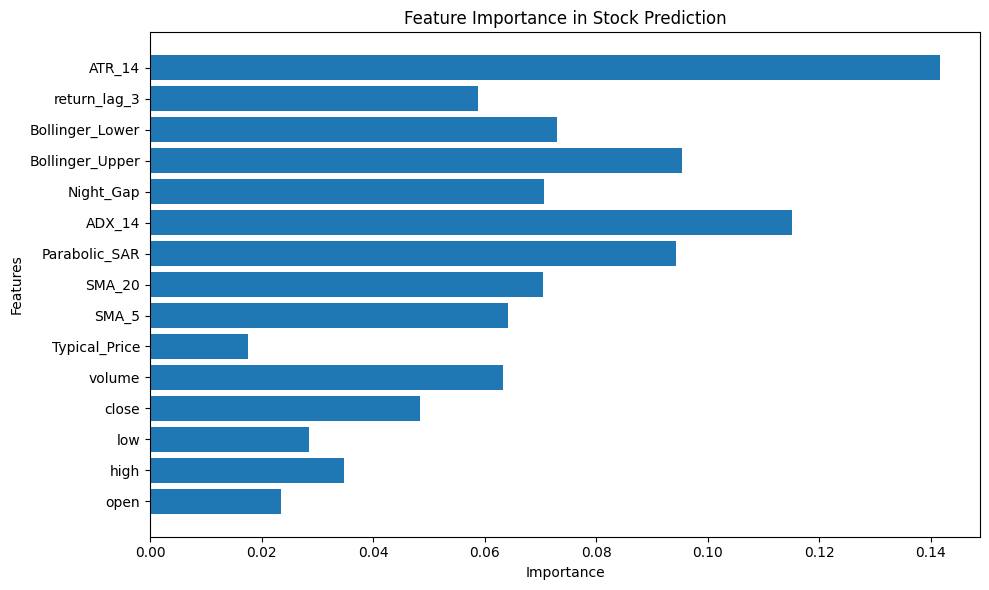

In [35]:
plt.figure(figsize=(10, 6))
plt.barh(final_features, gb_hyp_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Stock Prediction')
plt.tight_layout()
plt.show()

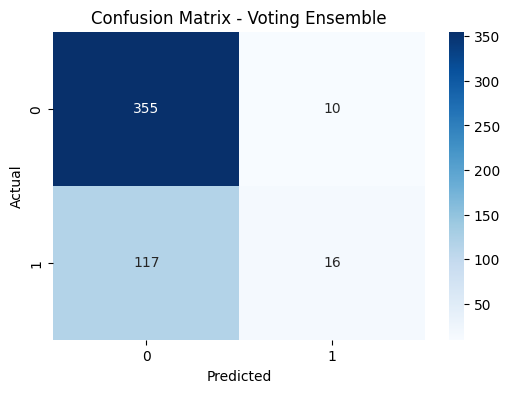

In [36]:
conf_matrix = confusion_matrix(y_test, predictions_gb_hyp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {name}')
plt.show()

In [37]:
def predict_trending_stocks_gbc(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        if not stock_data.empty:
            X_future = stock_data[final_features].dropna().tail(1)
            if not X_future.empty:
                X_future_scaled = scaler.transform(X_future)
                prediction = model.predict(X_future_scaled)[0]
                tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
            else:
                tomorrow_predictions[ticker] = "No Data"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [38]:
trending_stocks = predict_trending_stocks_gbc(all_data, gb_hyp_model, scaler)
print("Trending Stocks for Tomorrow(GBC):")
print(trending_stocks)

Trending Stocks for Tomorrow(GBC):
{'HDB': 'Down'}


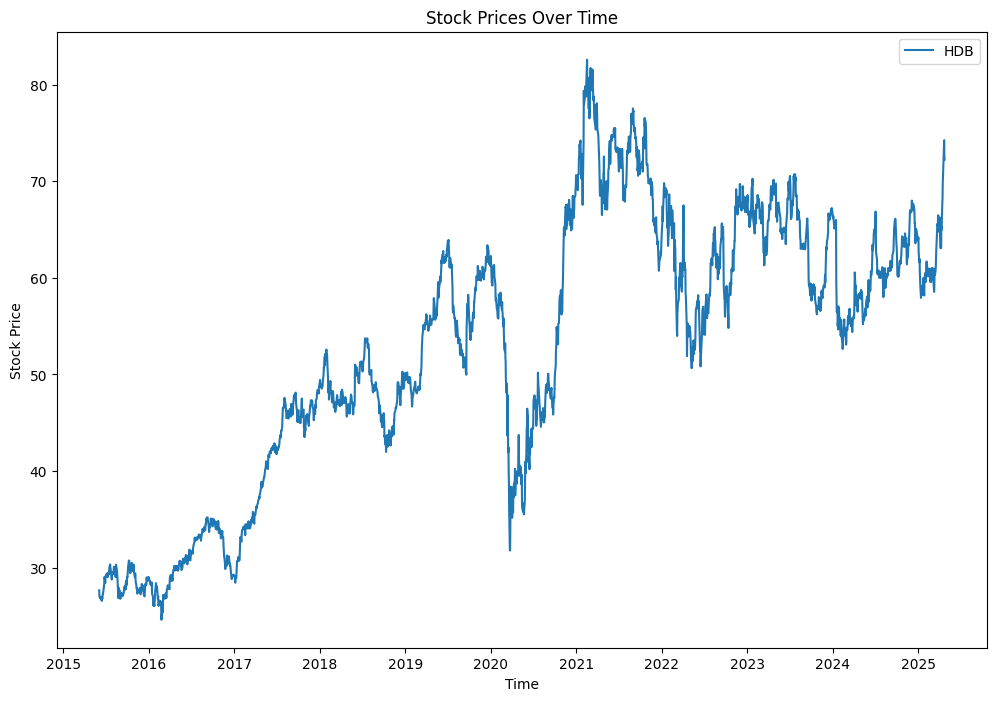

In [39]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [40]:
#Using Tenserflow

In [41]:
#Using LSTM
def prepare_lstm_data(X, y, time_steps=10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:(i + time_steps)])
        y_lstm.append(y.iloc[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

In [42]:
time_steps = 10
X_lstm, y_lstm = prepare_lstm_data(X_train, y_train, time_steps)
X_lstm_test, y_lstm_test = prepare_lstm_data(X_test, y_test, time_steps)

In [43]:
# Enhanced LSTM
lstm_model = Sequential([
    Input(shape=(time_steps, X.shape[1])),
    LSTM(128, activation='tanh', recurrent_activation='sigmoid', 
        return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [44]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                             patience=3, min_lr=0.0001)
lstm_model.compile(optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [45]:
history_lstm = lstm_model.fit(X_lstm, y_lstm, 
                            validation_split=0.2, 
                            epochs=50, 
                            batch_size=64, 
                            callbacks=[early_stopping, reduce_lr],
                            verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5609 - loss: 0.9368 - precision: 0.2980 - recall: 0.4298 - val_accuracy: 0.6877 - val_loss: 0.8273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6991 - loss: 0.8137 - precision: 0.3732 - recall: 0.1320 - val_accuracy: 0.6877 - val_loss: 0.8109 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7064 - loss: 0.7892 - precision: 0.4157 - recall: 0.1633 - val_accuracy: 0.6826 - val_loss: 0.7948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7285 - loss: 0.7586 - precision: 0.5219 - recall: 0.1390 - val_accuracy: 0.6776 - val_loss: 0.7718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━

In [46]:
metrics = lstm_model.evaluate(X_lstm_test, y_lstm_test, verbose=0)
lstm_loss = metrics[0]
lstm_accuracy = metrics[1]
print(f"LSTM Model Loss: {metrics[0]:.4f}")
print(f"LSTM Model Accuracy: {metrics[1]:.4f}")

LSTM Model Loss: 0.7667
LSTM Model Accuracy: 0.7111


In [47]:
predictions_lstm = (lstm_model.predict(X_lstm_test) > 0.5).astype(int).flatten()
y_proba_lstm = lstm_model.predict(X_lstm_test).flatten()

accuracy_lstm = accuracy_score(y_lstm_test, predictions_lstm)
f1_lstm = f1_score(y_lstm_test, predictions_lstm)
precision_lstm = precision_score(y_lstm_test, predictions_lstm)
recall_lstm = recall_score(y_lstm_test, predictions_lstm)
mse_lstm = mean_squared_error(y_lstm_test, y_proba_lstm)
mae_lstm = mean_absolute_error(y_lstm_test, y_proba_lstm)
auc_lstm = roc_auc_score(y_lstm_test, y_proba_lstm)
lloss_lstm = log_loss(y_lstm_test, y_proba_lstm)

print(f"\nLSTM Model Evaluation:")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"F1 Score: {f1_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"MSE: {mse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"AUC-ROC: {auc_lstm:.4f}")
print(f"Log Loss: {lloss_lstm:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

LSTM Model Evaluation:
Accuracy: 0.7111
F1 Score: 0.0662
Precision: 0.2500
Recall: 0.0382
MSE: 0.2050
MAE: 0.4150
AUC-ROC: 0.5090
Log Loss: 0.5998


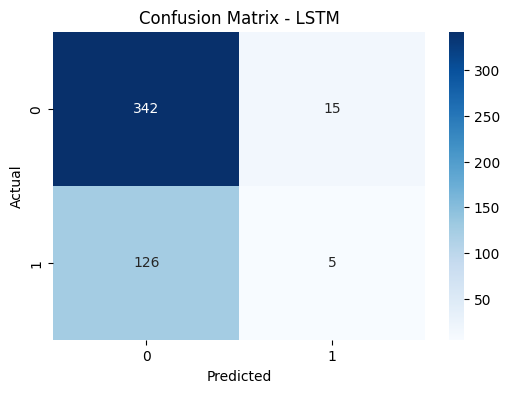

In [48]:
conf_matrix_lstm = confusion_matrix(y_lstm_test, predictions_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

In [49]:
def predict_trends_lstm(data, model, time_steps=5):
    tomorrow_predictions = {}
    for ticker in tickers:
        if ticker in data:
            stock_data = data[ticker]
            if len(stock_data) >= time_steps:
                X_future = stock_data[final_features].tail(time_steps).values
                X_future = X_future.reshape((1, time_steps, X_future.shape[1]))
                prediction = model.predict(X_future)
                tomorrow_predictions[ticker] = "Up" if prediction > 0.5 else "Down"
            else:
                tomorrow_predictions[ticker] = "No Data"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [50]:
trending_stocks_lstm = predict_trends_lstm(all_data, lstm_model)
print("Predicted Trending Stocks for Tomorrow (LSTM):")
print(trending_stocks_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Predicted Trending Stocks for Tomorrow (LSTM):
{'HDB': 'Up'}


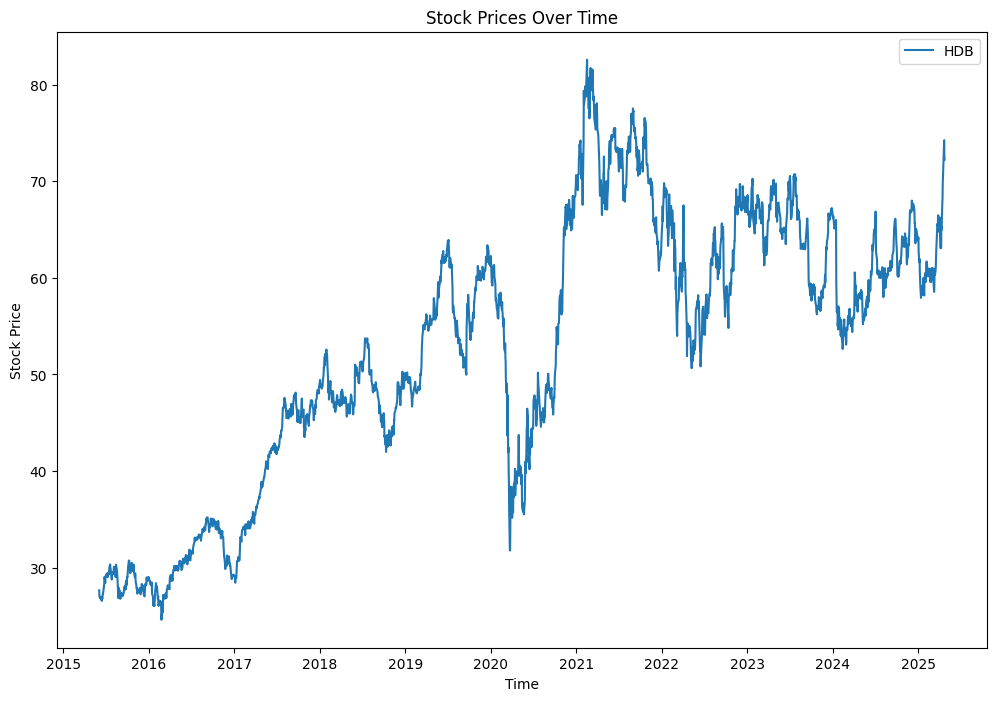

In [51]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [52]:
#Dense Neural Network
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    BatchNormalization(),
    Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(1, activation='sigmoid')
])
dnn_model.compile(optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_dnn = dnn_model.fit(X_train, y_train,
                          validation_split=0.2,
                          epochs=50,
                          batch_size=64,
                          callbacks=[early_stopping, reduce_lr],
                          verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6456 - loss: 0.8594 - precision_1: 0.3413 - recall_1: 0.2088 - val_accuracy: 0.6892 - val_loss: 0.8164 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6895 - loss: 0.8154 - precision_1: 0.3837 - recall_1: 0.0736 - val_accuracy: 0.6892 - val_loss: 0.8056 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6955 - loss: 0.7904 - precision_1: 0.4411 - recall_1: 0.1006 - val_accuracy: 0.6892 - val_loss: 0.7897 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7055 - loss: 0.7766 - precision_1: 0.5155 - recall_1: 0.1000 - val_accuracy: 0.6892 - val_loss: 0.7796 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch

In [54]:
metrics = dnn_model.evaluate(X_test, y_test, verbose=0)
dnn_loss = metrics[0]
dnn_accuracy = metrics[1]
print(f"\nDNN Model Loss: {dnn_loss:.4f}")
print(f"DNN Model Accuracy: {dnn_accuracy:.4f}")


DNN Model Loss: 0.6629
DNN Model Accuracy: 0.7590


In [55]:
predictions_dnn = (dnn_model.predict(X_test) > 0.5).astype(int).flatten()
y_proba_dnn = dnn_model.predict(X_test).flatten()

accuracy_dnn = accuracy_score(y_test, predictions_dnn)
f1_dnn = f1_score(y_test, predictions_dnn)
precision_dnn = precision_score(y_test, predictions_dnn)
recall_dnn = recall_score(y_test, predictions_dnn)
mse_dnn = mean_squared_error(y_test, y_proba_dnn)
mae_dnn = mean_absolute_error(y_test, y_proba_dnn)
auc_dnn = roc_auc_score(y_test, y_proba_dnn)
lloss_dnn = log_loss(y_test, y_proba_dnn)

print(f"\nDNN Model Evaluation:")
print(f"Accuracy: {accuracy_dnn:.4f}")
print(f"F1 Score: {f1_dnn:.4f}")
print(f"Precision: {precision_dnn:.4f}")
print(f"Recall: {recall_dnn:.4f}")
print(f"MSE: {mse_dnn:.4f}")
print(f"MAE: {mae_dnn:.4f}")
print(f"AUC-ROC: {auc_dnn:.4f}")
print(f"Log Loss: {lloss_dnn:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

DNN Model Evaluation:
Accuracy: 0.7590
F1 Score: 0.2308
Precision: 0.7826
Recall: 0.1353
MSE: 0.1858
MAE: 0.3510
AUC-ROC: 0.6156
Log Loss: 0.5605


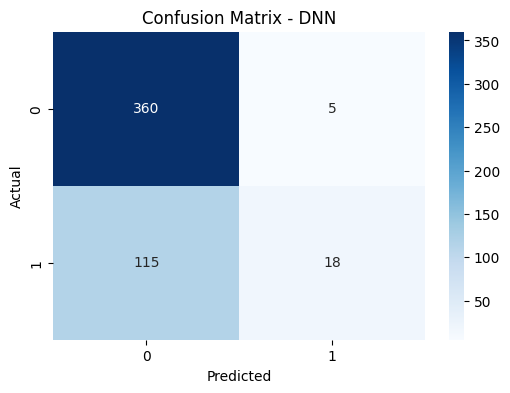

In [56]:
conf_matrix_dnn = confusion_matrix(y_test, predictions_dnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DNN')
plt.show()

In [57]:
def predict_trending_stocks_dnn(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        if ticker in data:
            stock_data = data[ticker]
            X_future = stock_data[final_features].tail(1)
            if not X_future.empty:
                X_future_scaled = scaler.transform(X_future)
                prediction = model.predict(X_future_scaled)[0]
                tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
            else:
                tomorrow_predictions[ticker] = "No Data"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [58]:
trending_stocks_dnn = predict_trending_stocks_dnn(all_data, dnn_model, scaler)
print("Trending Stocks for Tomorrow (Dense Neural Network):")
print(trending_stocks_dnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Trending Stocks for Tomorrow (Dense Neural Network):
{'HDB': 'Down'}


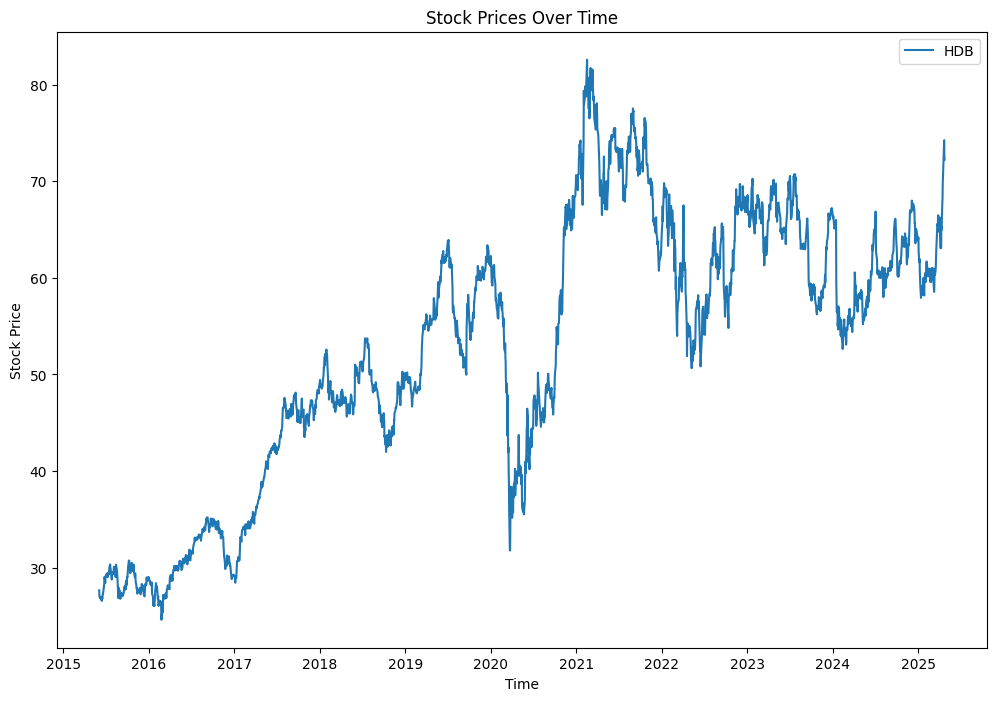

In [59]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()